In [1]:
import os
import sys
import pandas as pd
import numpy as np
from obspy import read
from glob import glob
import matplotlib.pyplot as plt
%matplotlib widget
sys.path.append('..')
import core.feature_extraction as fe

In [2]:
# Get test_dataset_1 data
wf_data = os.path.join('..','data','test_dataset_1','UW','GNW','UW.GNW..EN?.2017*.mseed')

ml_pred = os.path.join('..','data','test_dataset_1','UW','GNW','UW.GNW.EW.EN?.2017.131.mseed')
st = read(ml_pred,fmt='MSEED')
for _f in glob(wf_data):
    st += read(_f, fmt='MSEED')
st.merge(method=1).trim(endtime=st[0].stats.starttime + 3600)

6 Trace(s) in Stream:
UW.GNW..ENE   | 2017-05-11T00:00:00.005000Z - 2017-05-11T01:00:00.005000Z | 100.0 Hz, 360001 samples
UW.GNW..ENN   | 2017-05-11T00:00:00.005000Z - 2017-05-11T01:00:00.005000Z | 100.0 Hz, 360001 samples
UW.GNW..ENZ   | 2017-05-11T00:00:00.005000Z - 2017-05-11T01:00:00.005000Z | 100.0 Hz, 360001 samples
UW.GNW.EW.END | 2017-05-11T00:00:05.005000Z - 2017-05-11T01:00:00.005000Z | 100.0 Hz, 359501 samples
UW.GNW.EW.ENP | 2017-05-11T00:00:05.005000Z - 2017-05-11T01:00:00.005000Z | 100.0 Hz, 359501 samples
UW.GNW.EW.ENS | 2017-05-11T00:00:05.005000Z - 2017-05-11T01:00:00.005000Z | 100.0 Hz, 359501 samples

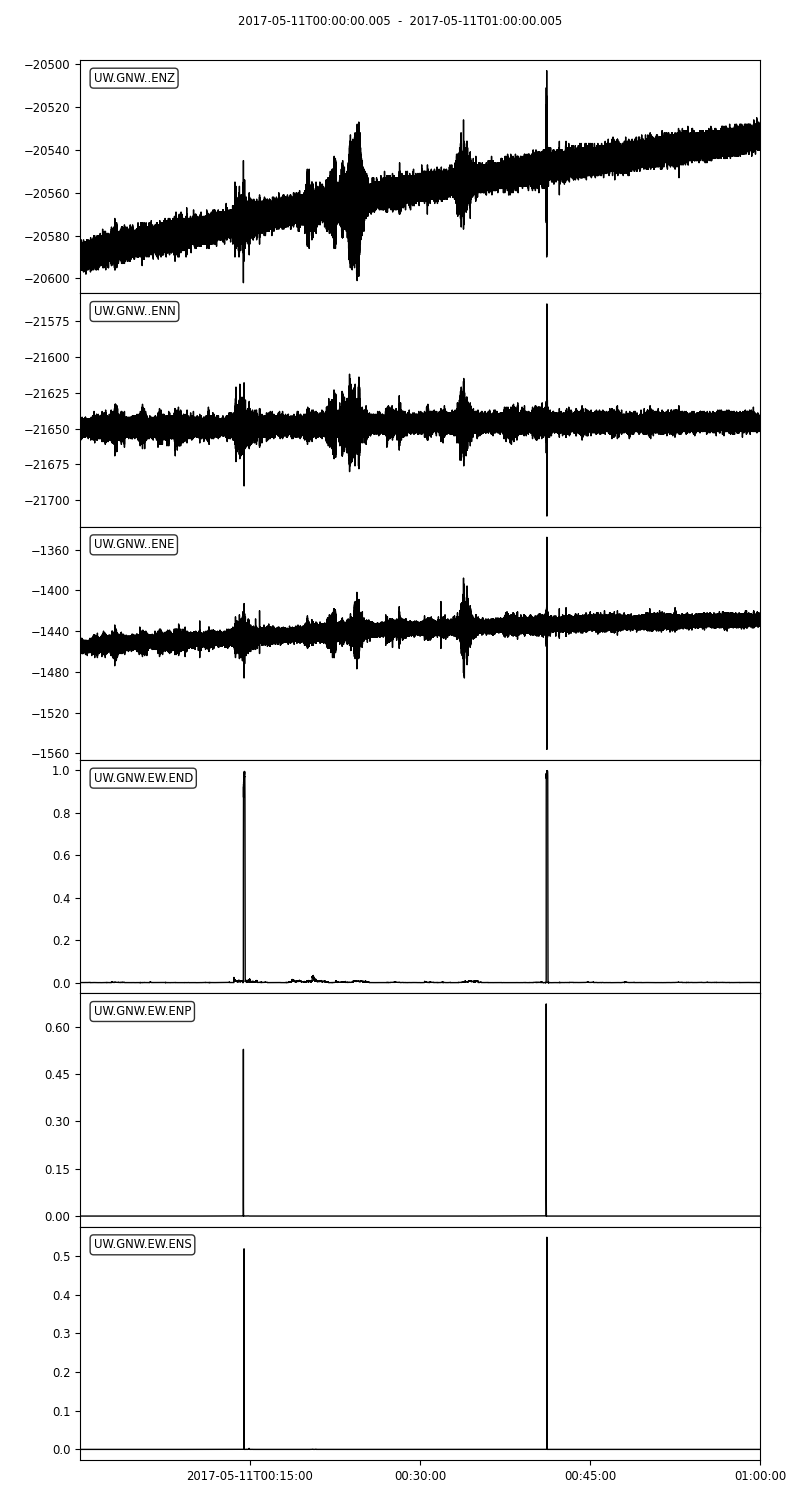

6 Trace(s) in Stream:
UW.GNW..ENE   | 2017-05-11T00:00:00.005000Z - 2017-05-11T01:00:00.005000Z | 100.0 Hz, 360001 samples
UW.GNW..ENN   | 2017-05-11T00:00:00.005000Z - 2017-05-11T01:00:00.005000Z | 100.0 Hz, 360001 samples
UW.GNW..ENZ   | 2017-05-11T00:00:00.005000Z - 2017-05-11T01:00:00.005000Z | 100.0 Hz, 360001 samples
UW.GNW.EW.END | 2017-05-11T00:00:05.005000Z - 2017-05-11T01:00:00.005000Z | 100.0 Hz, 359501 samples
UW.GNW.EW.ENP | 2017-05-11T00:00:05.005000Z - 2017-05-11T01:00:00.005000Z | 100.0 Hz, 359501 samples
UW.GNW.EW.ENS | 2017-05-11T00:00:05.005000Z - 2017-05-11T01:00:00.005000Z | 100.0 Hz, 359501 samples

In [3]:
st.plot(equal_scale=False)
st

In [40]:
from importlib import reload
reload(fe)

<module 'core.feature_extraction' from '/Users/nates/Code/Sci-Prod-ML/ml_prediction/notebooks/../core/feature_extraction.py'>

In [32]:
# Try out the core feature_extraction process
tr = st.select(channel='??P')[0]
df_pick = fe.process_predictions(
    tr, thr_on=0.1, thr_off=0.1, fit_pad_sec=0.0, fit_thr_coef=0.125, ndata_bounds=[10,9e99],
)
# triggers = fe.trigger_onset(tr.data,0.1,0.1)
# display(triggers)

In [33]:
display(df_pick.T)

,0,1
et_on,1.494462e+09,1.494463e+09
et_off,1.494462e+09,1.494463e+09
p_scale,5.279133e-01,6.716610e-01
et_mean,1.494462e+09,1.494463e+09
et_max,1.494462e+09,1.494463e+09
det_obs_prob,NaN,NaN
et_std,1.275000e-01,1.275000e-01
L2 res,3.055990e-01,4.046592e-01
ndata,5.200000e+01,5.200000e+01
C_pp,1.526675e+15,3.885906e+15


In [34]:
ml_tr = st.select(channel="??P")[0]
x = ml_tr.times(type="timestamp")
y = ml_tr.data
_S = df_pick.iloc[0,:]
pp = _S[['p_scale','et_mean','et_std']].values
display(pp)
y_hat = fe.scaled_normal_pdf(pp,x)
display(y_hat)

array([5.27913332e-01, 1.49446166e+09, 1.27499998e-01])

array([0., 0., 0., ..., 0., 0., 0.])

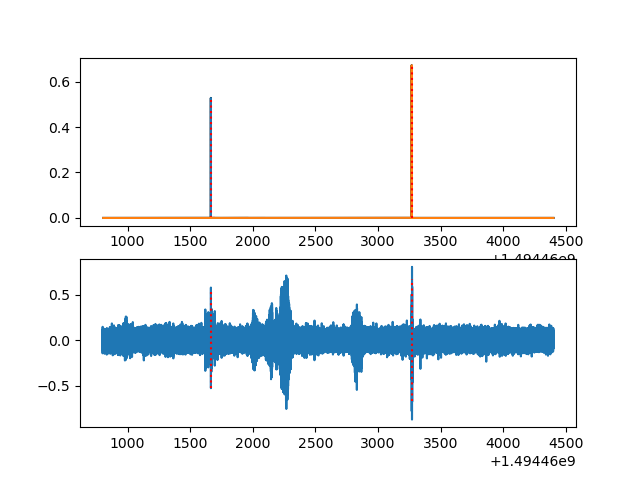

In [36]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)

ax1.plot(x, y, "k-")
for _i in range(len(df_pick)):
    _S = df_pick.iloc[_i, :]
    y_hat = fe.scaled_normal_pdf(_S[["p_scale", "et_mean", "et_std"]].values, x)
    ax1.plot(x, y_hat)
    ax1.plot([_S["et_max"]] * 2, [0, _S["p_scale"]], "r:")

ax2.plot(st.select(channel="??Z")[0].times(type='timestamp'),
         st.select(channel="??Z")[0].copy().detrend().normalize().filter('bandpass', freqmin=1, freqmax=45).data)
# ax1.set_xlim([pp[1] - 10 * pp[2], pp[1] + 10 * pp[2]])


for _i in range(len(df_pick)):
    _S = df_pick.iloc[_i, :]
    y_hat = fe.scaled_normal_pdf(_S[["p_scale", "et_mean", "et_std"]].values, x)
    ax2.plot([_S["et_max"]] * 2, np.array([-1,1])*_S["p_scale"], "r:")
